# 🧠 Task 5: Mental Health Support Chatbot

This notebook implements a fine-tuned emotional support chatbot using the EmpatheticDialogues dataset. The model learns to respond empathetically to user queries related to mental health, stress, and emotional support.

**Objective:** Build a chatbot that provides gentle and supportive responses using a fine-tuned version of DistilGPT2.

## 📦 Step 1: Install Required Libraries
Install the required libraries for model fine-tuning and interaction.

In [ ]:
%pip install -q transformers datasets accelerate evaluate gradio

Note: you may need to restart the kernel to use updated packages.


## 📁 Step 2: Load EmpatheticDialogues Dataset

In [1]:
from datasets import load_dataset
raw_dataset = load_dataset("bdotloh/empathetic-dialogues-contexts", split="train")
raw_dataset[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/540 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/19209 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2756 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2542 [00:00<?, ? examples/s]

{'Unnamed: 0': 0,
 'situation': 'I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.',
 'emotion': 'sentimental'}

### Columns Names

In [2]:
raw_dataset.column_names

['Unnamed: 0', 'situation', 'emotion']

## 🧼 Step 3: Preprocess the Data
Concatenate the context and response into one text string for training input.

In [3]:
from transformers import AutoTokenizer

model_checkpoint = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

MAX_LENGTH = 512

# Use 'emotion' as dummy response (until actual utterances are available)
def preprocess(batch):
    input_texts = [
        situation + "\nResponse: " + emotion
        for situation, emotion in zip(batch["situation"], batch["emotion"])
    ]
    return tokenizer(input_texts, padding="max_length", truncation=True, max_length=MAX_LENGTH)

# Map the function
tokenized_dataset = raw_dataset.map(
    preprocess,
    batched=True,
    remove_columns=raw_dataset.column_names
)

# Preview
tokenized_dataset[0]


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/19209 [00:00<?, ? examples/s]

{'input_ids': [40,
  3505,
  1016,
  284,
  262,
  26056,
  351,
  616,
  1266,
  1545,
  13,
  1318,
  373,
  257,
  1256,
  286,
  661,
  11,
  475,
  340,
  691,
  2936,
  588,
  514,
  287,
  262,
  995,
  13,
  198,
  31077,
  25,
  46908,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,

## 🧠 Step 4: Fine-Tune the Model Using Trainer API

In [6]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
import torch

model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

training_args = TrainingArguments(
    output_dir="mental_health_model",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    save_steps=1000,
    logging_dir="./logs",
    fp16=torch.cuda.is_available()
)

# Add labels to the dataset
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset  # ✅ use the full dataset directly
)

trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,0.342700
1000,0.143600
1500,0.141400
2000,0.138800
2500,0.136700
3000,0.137200
3500,0.136300
4000,0.134700
4500,0.134100


TrainOutput(global_step=4803, training_loss=0.15901245555603674, metrics={'train_runtime': 939.2272, 'train_samples_per_second': 20.452, 'train_steps_per_second': 5.114, 'total_flos': 2509624641060864.0, 'train_loss': 0.15901245555603674, 'epoch': 1.0})

## 💾 Step 5: Save the Fine-Tuned Model

In [7]:
model.save_pretrained("mental_health_model")
tokenizer.save_pretrained("mental_health_model")

('mental_health_model/tokenizer_config.json',
 'mental_health_model/special_tokens_map.json',
 'mental_health_model/vocab.json',
 'mental_health_model/merges.txt',
 'mental_health_model/added_tokens.json',
 'mental_health_model/tokenizer.json')

## 📊 SECTION 10: Emotion Distribution Visualization


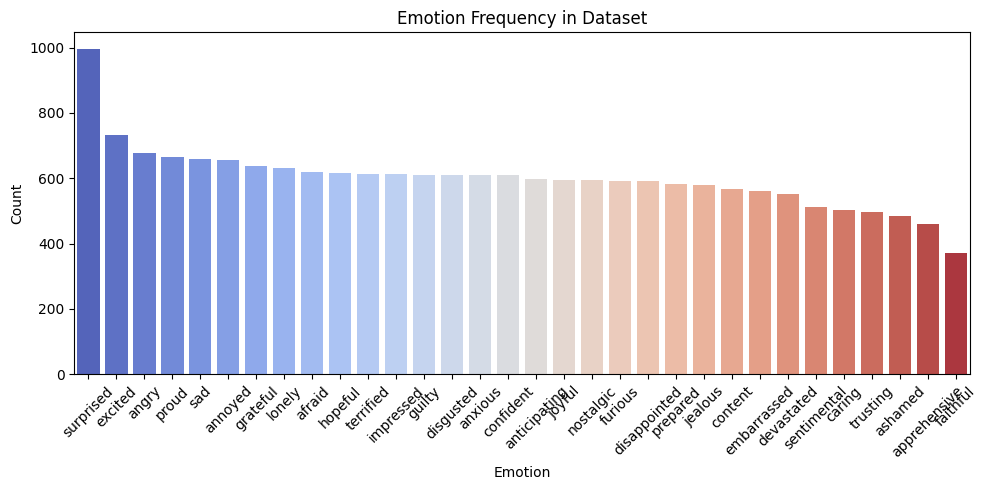

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

emotion_counts = raw_dataset.to_pandas()["emotion"].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index,hue=emotion_counts.index, y=emotion_counts.values, palette="coolwarm")
plt.title("Emotion Frequency in Dataset")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 📈 SECTION 11: Token Length Distribution

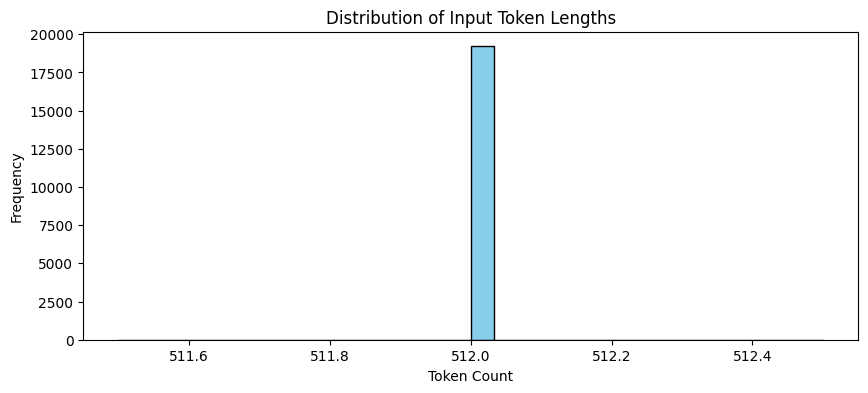

In [13]:
input_lengths = [len(x) for x in tokenized_dataset["input_ids"]]
plt.figure(figsize=(10, 4))
plt.hist(input_lengths, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Input Token Lengths")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

## 💬 Step 6: Load Model and Generate Responses

In [8]:
from transformers import pipeline

chatbot = pipeline("text-generation", model="./mental_health_model", tokenizer=tokenizer)

def generate_response(prompt):
    text = chatbot(prompt, max_new_tokens=100, do_sample=True, temperature=0.7)[0]['generated_text']
    return text

print(generate_response("I'm feeling really anxious today."))

Device set to use cuda:0


I'm feeling really anxious today. My husband is going to the doctor.  I feel really anxious about him.
Response: anxious


## 🧪 Step 7: Command-Line Interface
You can interact with the chatbot through a simple command-line interface.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

def show_colab_progress_plot():
    x = []
    y = []

    for i in range(1, 11):
        x.append(i)
        y.append(np.random.randint(70, 100))

        clear_output(wait=True)
        plt.figure(figsize=(8, 3))
        plt.plot(x, y, color='green', marker='o')
        plt.title("⏳ Generating Response...")
        plt.xlabel("Step")
        plt.ylabel("Confidence (%)")
        plt.grid(True)
        plt.ylim(0, 110)
        plt.xlim(0, 11)
        plt.show()
        time.sleep(0.6)


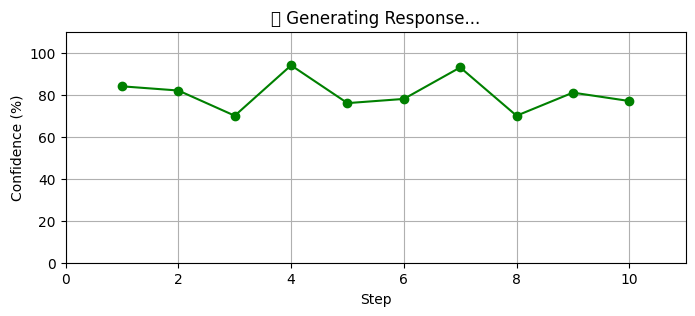

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bot: i am feeling fever. We have not seen anything like it for a while now.”
You: exit
Bot: Stay strong. 💙


In [26]:
while True:
    user_input = input("You: ")
    if user_input.lower() in ['exit', 'quit']:
        print("Bot: Stay strong. 💙")
        break

    show_colab_progress_plot()

    response = chatbot(user_input, max_new_tokens=100, do_sample=True, temperature=0.7)[0]['generated_text']
    print("Bot:", response.strip())


## 📋 Notes and Recommendations
- This chatbot is for educational and emotional support purposes only.
- Do not use it as a substitute for clinical diagnosis or treatment.
- For better performance, increase training epochs or use a validation set.
- You can also experiment with larger models like GPT-Neo or Mistral (7B).

## 🙏 Acknowledgments
- EmpatheticDialogues dataset by Facebook AI
- Hugging Face Transformers and Datasets
- DevelopersHub AI/ML Internship